<a href="https://colab.research.google.com/github/Aman-sys-ui/EDA/blob/main/customer_segmentation/Customer_Segmentation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv('/content/online_retail_II.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
df.shape

(1067371, 8)

In [ ]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235812 entries, 0 to 235811
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      235812 non-null  object 
 1   StockCode    235812 non-null  object 
 2   Description  233881 non-null  object 
 3   Quantity     235811 non-null  float64
 4   InvoiceDate  235811 non-null  object 
 5   Price        235811 non-null  float64
 6   Customer ID  183831 non-null  float64
 7   Country      235811 non-null  object 
dtypes: float64(3), object(5)
memory usage: 14.4+ MB


In [ ]:
df.describe()

,Quantity,Price,Customer ID
count,235811.000000,235811.000000,183831.000000
mean,10.814517,4.648349,15340.481235
std,117.551763,132.074273,1678.876080
min,-9200.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13975.000000
50%,3.000000,2.100000,15268.000000
75%,10.000000,4.250000,16807.000000
max,19152.000000,10953.500000,18287.000000


In [ ]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


In [ ]:
# Drop rows where Customer ID is missing
df = df.dropna(subset=['Customer ID'])

In [ ]:
# Optional: Remove rows with null product descriptions (only needed if doing product-level insights)
df = df.dropna(subset=['Description'])

In [ ]:
# Ensure Customer ID is treated as string to avoid issues
df['Customer ID'] = df['Customer ID'].astype(str)

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


# **Feature Engineering**

In [ ]:
df['TotalAmount'] = df['Quantity'] * df['Price']


In [ ]:
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['Weekday'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

# **EDA**

In [ ]:
print("Total Revenue:", df['TotalAmount'].sum())
print("Total Orders:", df['Invoice'].nunique())
print("Total Customers:", df['Customer ID'].nunique())


Total Revenue: 16648292.388
Total Orders: 44876
Total Customers: 5942


In [ ]:
df.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).head(10)


,TotalAmount
Description,
REGENCY CAKESTAND 3 TIER,269736.70
WHITE HANGING HEART T-LIGHT HOLDER,242700.51
JUMBO BAG RED RETROSPOT,134845.16
ASSORTED COLOUR BIRD ORNAMENT,126354.18
POSTAGE,112249.10
PARTY BUNTING,102686.23
PAPER CHAIN KIT 50'S CHRISTMAS,78366.93
CHILLI LIGHTS,72229.34
BLACK RECORD COVER FRAME,67127.15


<Axes: xlabel='YearMonth'>

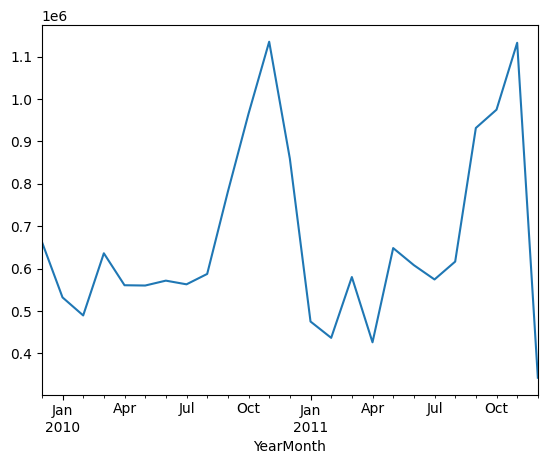

In [ ]:
df.groupby('YearMonth')['TotalAmount'].sum().plot(kind='line')


In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalAmount': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)  # This returns a NumPy array

# Optional: Convert back to DataFrame for easy plotting
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=['Recency', 'Frequency', 'Monetary'])


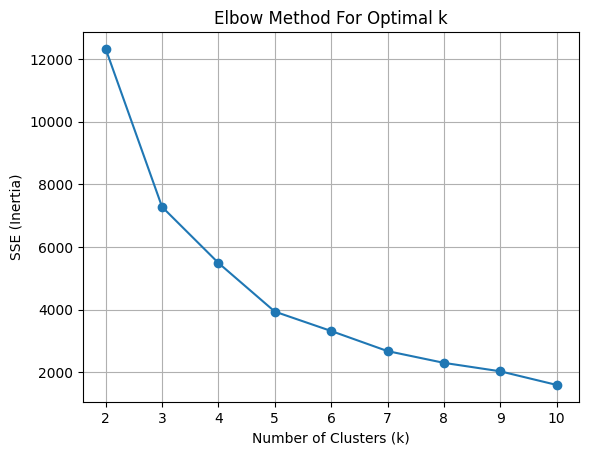

In [ ]:
#optimal K
sse = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(K_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [ ]:
kmeans

KMeans(n_clusters=4, random_state=42)

In [ ]:
rfm.groupby('Cluster').mean().round(2)


,Recency,Frequency,Monetary
Cluster,,,
0,471.64,2.54,602.49
1,24.88,47.83,20196.95
2,71.40,6.87,2085.34
3,3.33,220.67,230605.54


In [ ]:
rfm['Cluster'].value_counts()


,count
Cluster,
2,3701
0,1983
1,246
3,12


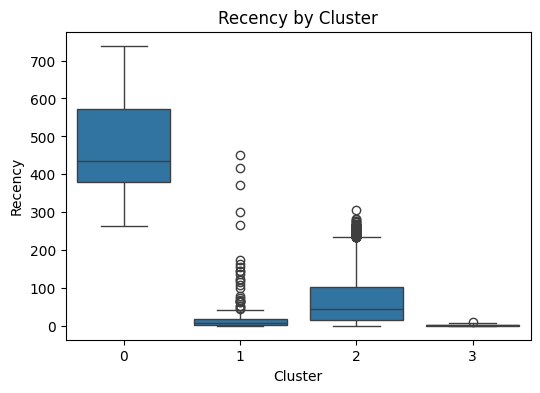

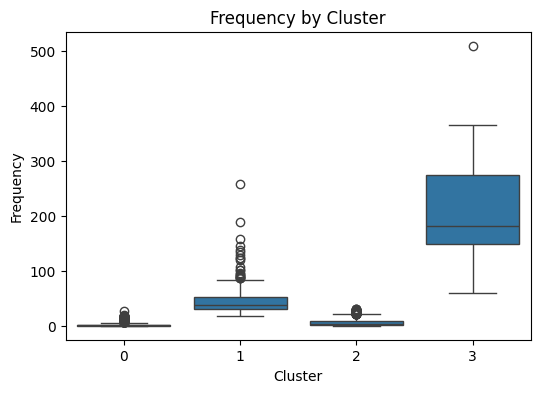

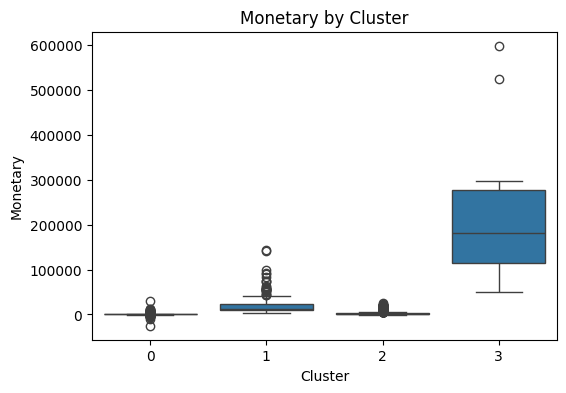

In [ ]:
for col in ['Recency', 'Frequency', 'Monetary']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Cluster', y=col, data=rfm)
    plt.title(f"{col} by Cluster")
    plt.show()


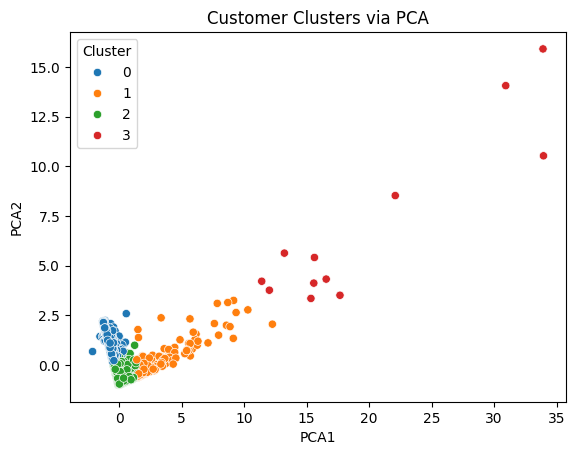

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title('Customer Clusters via PCA')
plt.show()


In [ ]:
cluster_labels = {
    0: 'Loyal Customers',
    1: 'At-Risk',
    2: 'Regular Buyers',
    3: 'New Customers'
}
rfm['Segment'] = rfm['Cluster'].map(cluster_labels)


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1, min_samples=5)  # You may need to tune eps
rfm['Cluster_DBSCAN'] = dbscan.fit_predict(rfm_scaled)


In [ ]:
rfm

,Recency,Frequency,Monetary,Cluster,PCA1,PCA2,Segment,Cluster_DBSCAN
Customer ID,,,,,,,,
12346.0,326,17,-64.68,0,0.060627,0.543989,Loyal Customers,0
12347.0,2,8,5633.32,2,0.488698,-0.795594,Regular Buyers,0
12348.0,75,5,2019.40,2,0.071874,-0.598894,Regular Buyers,0
12349.0,19,5,4404.54,2,0.276251,-0.780222,Regular Buyers,0
12350.0,310,1,334.40,0,-0.572235,0.343293,Loyal Customers,0
...,...,...,...,...,...,...,...,...
18283.0,4,22,2736.65,2,0.945477,-0.738443,Regular Buyers,0
18284.0,430,2,436.68,0,-0.727856,0.876379,Loyal Customers,0
18285.0,661,1,427.00,0,-1.160928,1.871319,Loyal Customers,0


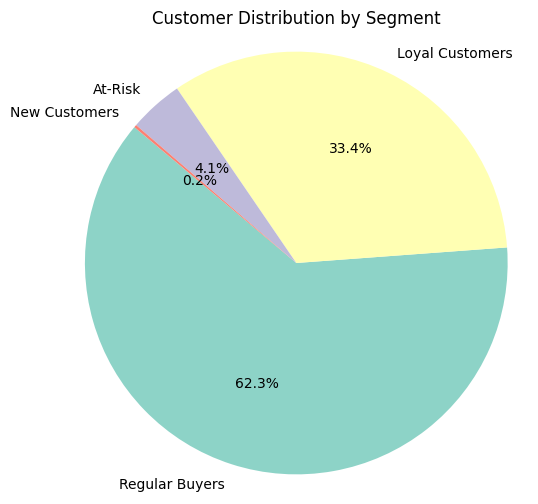

In [ ]:
# Count of customers per segment
segment_counts = rfm['Segment'].value_counts()

# Plot
plt.figure(figsize=(6, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Customer Distribution by Segment')
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart
plt.show()


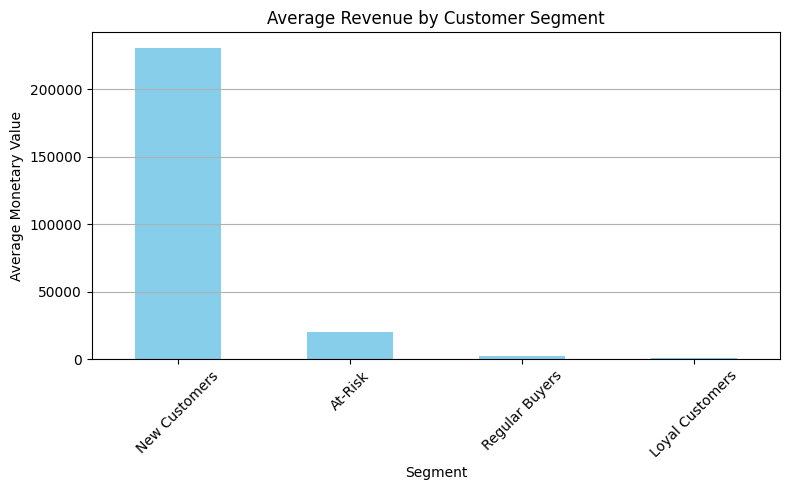

In [ ]:
# Average revenue per segment
segment_monetary = rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
segment_monetary.plot(kind='bar', color='skyblue')
plt.title('Average Revenue by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('Average Monetary Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
